In [2]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications import ResNet50 
from keras.applications.vgg16 import preprocess_input
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, log_loss

import warnings
warnings.filterwarnings('ignore')

In [3]:
SIZE = 256 #Constant size throughout the model

In [4]:
train_images = []
train_labels = []

In [5]:
for directory_path in glob.glob("/kaggle/input/cred-card/Dataset_final/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
#Capture test/validation data and labels into respective lists
test_images = []
test_labels = []
for directory_path in glob.glob("/kaggle/input/cred-card/Dataset_final/test/*"):
    label1 = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label1)

In [8]:
#Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [9]:
x_test = np.array(x_test)
x_train, x_test = x_train / 255.0, x_test / 255.0

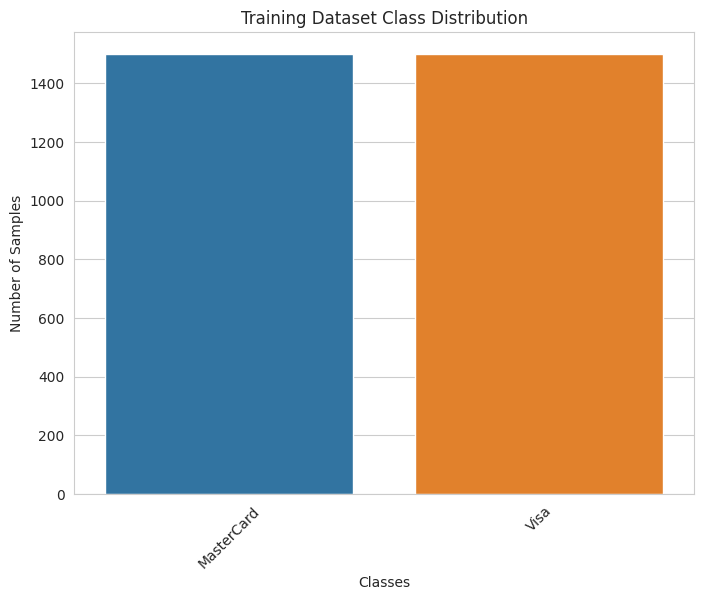

In [10]:
train_class_distribution = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=train_class_distribution.index, y=train_class_distribution.values)
plt.title('Training Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

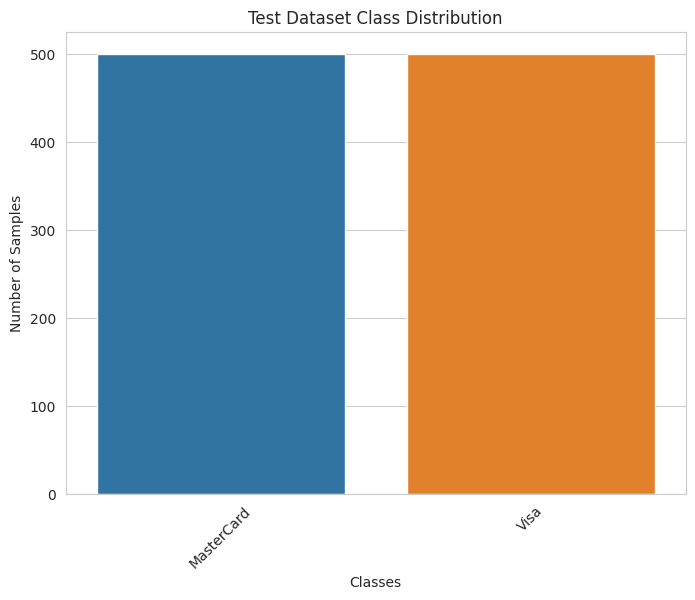

In [11]:
test_class_distribution = pd.Series(test_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=test_class_distribution.index, y=test_class_distribution.values)
plt.title('Test Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

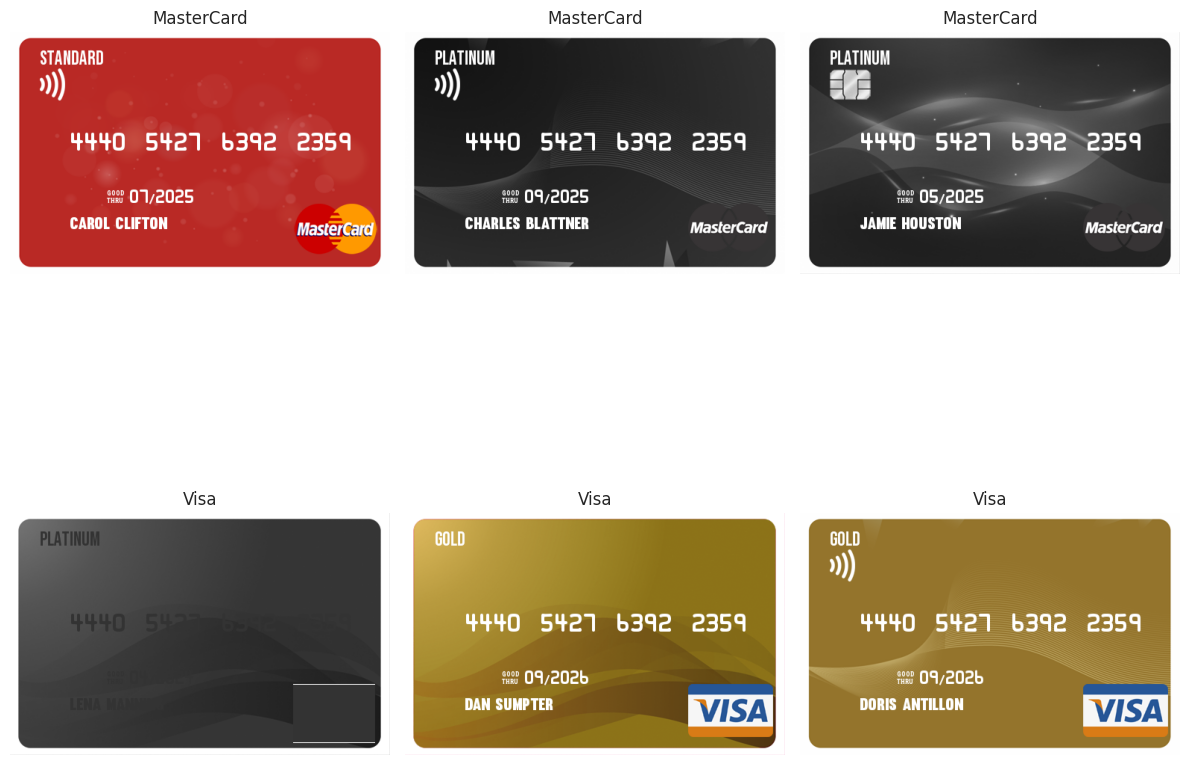

In [12]:
def display_sample_images(data_path, class_names, num_samples=3):
    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        sample_images = random.sample(glob.glob(os.path.join(class_path, "*.png")), num_samples)
        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name}')
    plt.tight_layout()
    plt.show()

train_path = "/kaggle/input/cred-card/Dataset_final/train"
class_names = os.listdir(train_path)  # List directories directly
display_sample_images(train_path, class_names)

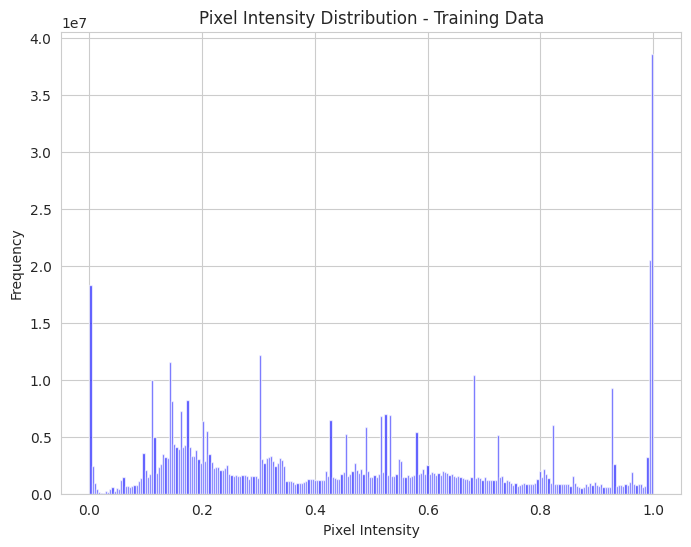

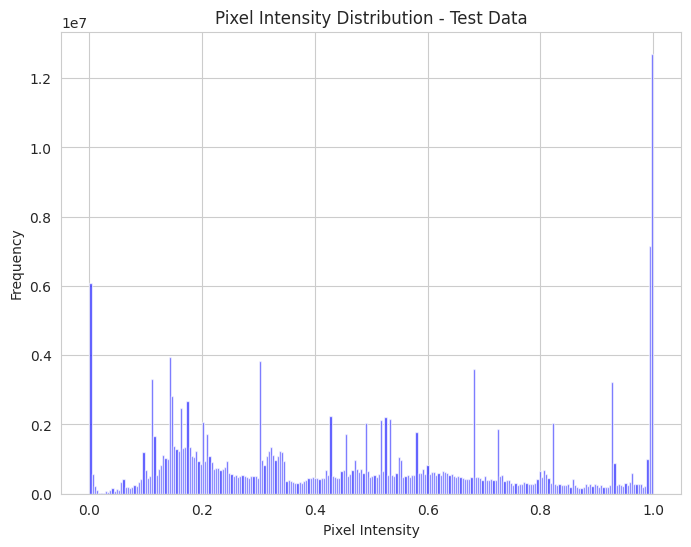

In [13]:
def plot_pixel_intensity_histogram(images, title):
    plt.figure(figsize=(8, 6))
    pixel_values = images.ravel()
    plt.hist(pixel_values, bins=256, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_histogram(x_train, 'Pixel Intensity Distribution - Training Data')

plot_pixel_intensity_histogram(x_test, 'Pixel Intensity Distribution - Test Data')

In [14]:
# Load ResNet50 model without the classifier (fully connected layers)
ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Make the layers non-trainable so as to use pre-trained weights
for layer in ResNet_model.layers:
    layer.trainable = False

ResNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# Feature extraction using ResNet50
# Extract features from the training images
train_features = ResNet_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten the features

# Extract features from the test images
test_features = ResNet_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten the features

I0000 00:00:1730733886.876308     113 service.cc:145] XLA service 0x7aaff414d520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730733886.876366     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730733886.876372     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/94 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step 

I0000 00:00:1730733892.041862     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step


In [16]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features, y_train)

# Predictions using XGBoost
predictions = xgb_model.predict(test_features)

In [17]:
# Classification Report
print("Classification Report:\n", classification_report(test_labels_encoded, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [18]:
accuracy = accuracy_score(test_labels_encoded, predictions)
print("Accuracy: ", accuracy)

loss = log_loss(test_labels_encoded, xgb_model.predict_proba(test_features))
print("Loss: ", loss)

Accuracy:  1.0
Loss:  0.0006171738942873595


<Axes: >

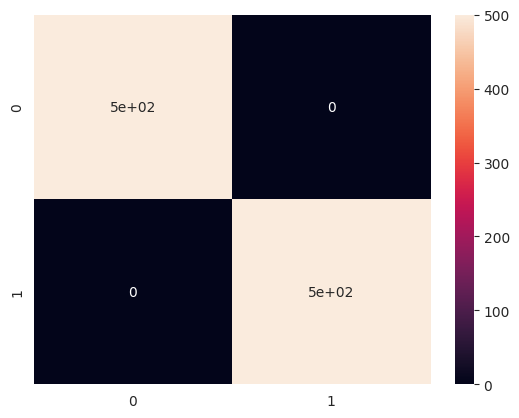

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predictions)
sns.heatmap(cm, annot=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The prediction for this image is:  ['Visa']
The actual label for this image is:  Visa


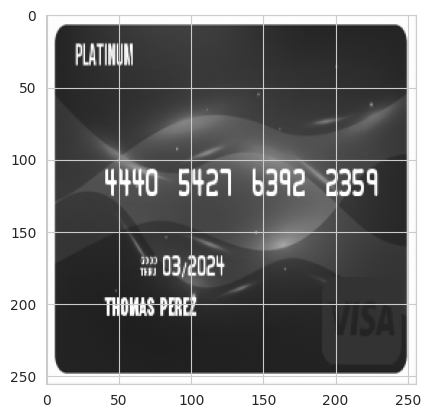

In [20]:
# Predictions on Random Test Image
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_features = ResNet_model.predict(input_img).reshape(1, -1)
prediction = xgb_model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The prediction for this image is:  ['MasterCard']
The actual label for this image is:  MasterCard


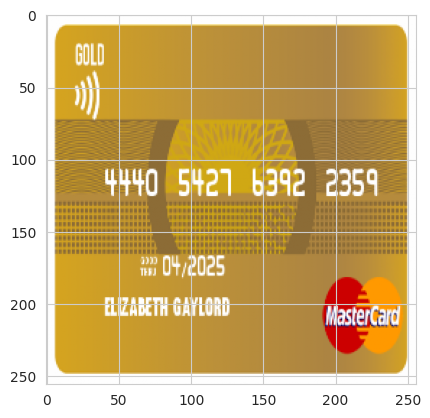

In [21]:
# Predictions on Random Test Image
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_features = ResNet_model.predict(input_img).reshape(1, -1)
prediction = xgb_model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])